In [9]:
import pandas as pd
from pathlib import Path
import json
import numpy as np
import geopandas as gpd
import folium
import branca.colormap as cm
import libpysal
import matplotlib.pyplot as plt
from shapely.geometry import shape, Point

from libpysal.weights import Queen, Rook, KNN
import splot
from esda.moran import Moran
from splot.esda import moran_scatterplot
import seaborn as sns
plt.rcParams["font.family"] = "serif"
import matplotlib

font = {
    # 'family' : 'normal',
    # 'weight' : 'bold',
    'size'   : 16
}

matplotlib.rc('font', **font)

In [10]:
ROOT = Path.cwd().parent.parent
RAW = ROOT / 'data' / 'raw'
PROCESSED = ROOT / 'data' / 'processed'
OUT = ROOT / 'out'
ANALYSIS = ROOT / 'data' / 'analysis'

In [11]:
gdf = gpd.read_file(ANALYSIS / 'clusters4.geojson', driver='GeoJSON')
df_schools = pd.read_excel(RAW / "school_lsoa_times.xlsx")
df_lookup = pd.read_csv(PROCESSED / "msoa_lookup.csv")

In [12]:

df_schools = df_schools.merge(df_lookup, on='lsoa', how='left')
df_schools = pd.DataFrame(df_schools.groupby('msoa')['mins_nearest_school'].mean()).reset_index()
df_schools

,msoa,mins_nearest_school
0,E02000001,7.499537
1,E02000002,7.304404
2,E02000003,7.004826
3,E02000004,7.503774
4,E02000005,7.028297
...,...,...
6835,E02007112,8.444340
6836,E02007113,7.859861
6837,E02007114,7.320928
6838,E02007115,7.061845


In [13]:
gdf2 = gdf.merge(df_schools, on='msoa', how='left')


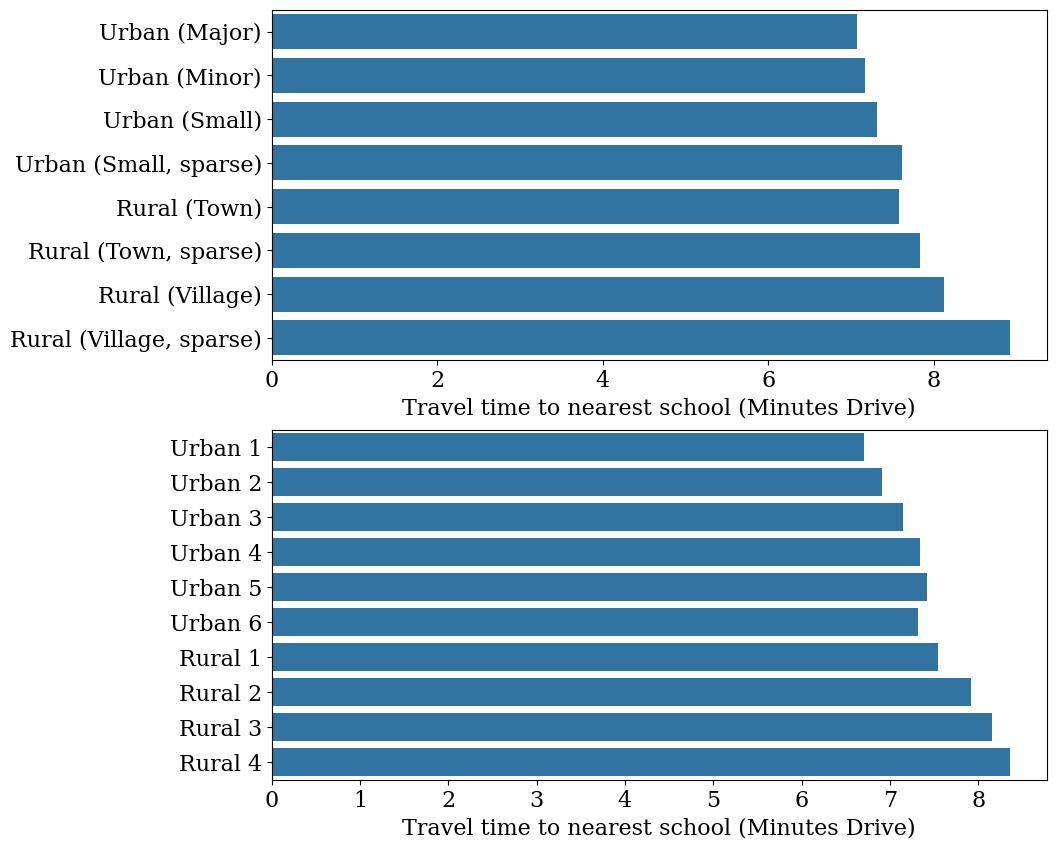

In [14]:
df_times_defra = pd.DataFrame(gdf2.groupby('rural_urban_category').mins_nearest_school.mean()).reset_index()

defra_map = {
    "Urban major conurbation": "Urban (Major)",
    'Urban minor conurbation': "Urban (Minor)",
    'Urban city and town': "Urban (Small)",
    'Urban city and town in a sparse setting': "Urban (Small, sparse)",
    'Rural town and fringe': "Rural (Town)",
    'Rural town and fringe in a sparse setting': "Rural (Town, sparse)",
    'Rural village and dispersed': "Rural (Village)",
    'Rural village and dispersed in a sparse setting': "Rural (Village, sparse)"}
df_times_defra['rural_urban_category'] = df_times_defra['rural_urban_category'].map(defra_map)
df_times_defra.rural_urban_category = df_times_defra.rural_urban_category.astype('category')
df_times_defra.rural_urban_category = df_times_defra.rural_urban_category.cat.set_categories(list(defra_map.values()))
# df.Tm = df.Tm.astype("category")
# df.Tm = df.Tm.cat.set_categories(sorter)
df_times_new = pd.DataFrame(gdf2.groupby('cluster_name_km_2').mins_nearest_school.mean()).reset_index()
df_times_new.cluster_name_km_2 = df_times_new.cluster_name_km_2.astype('category')
km_2_map = {
    0: "Urban 1",
    3: "Urban 2",
    5: "Urban 3",
    7: "Urban 4",
    1: "Urban 5",
    8: "Urban 6",
    2: "Rural 1",
    9: "Rural 2",
    4: "Rural 3",
    6: "Rural 4",
}
df_times_new.cluster_name_km_2 = df_times_new.cluster_name_km_2.cat.set_categories(list(km_2_map.values()))

fig, ax = plt.subplots(2, figsize=(10,10))
sns.barplot(x='mins_nearest_school',y='rural_urban_category',data=df_times_defra, ax=ax[0])
sns.barplot(x='mins_nearest_school',y='cluster_name_km_2',data=df_times_new, ax=ax[1])
ax[0].set_xlabel('Travel time to nearest school (Minutes Drive)')
ax[1].set_xlabel('Travel time to nearest school (Minutes Drive)')
ax[0].set_ylabel('')
ax[1].set_ylabel('')
fig.savefig(OUT / 'school_travel_time.png', bbox_inches='tight', dpi=300)

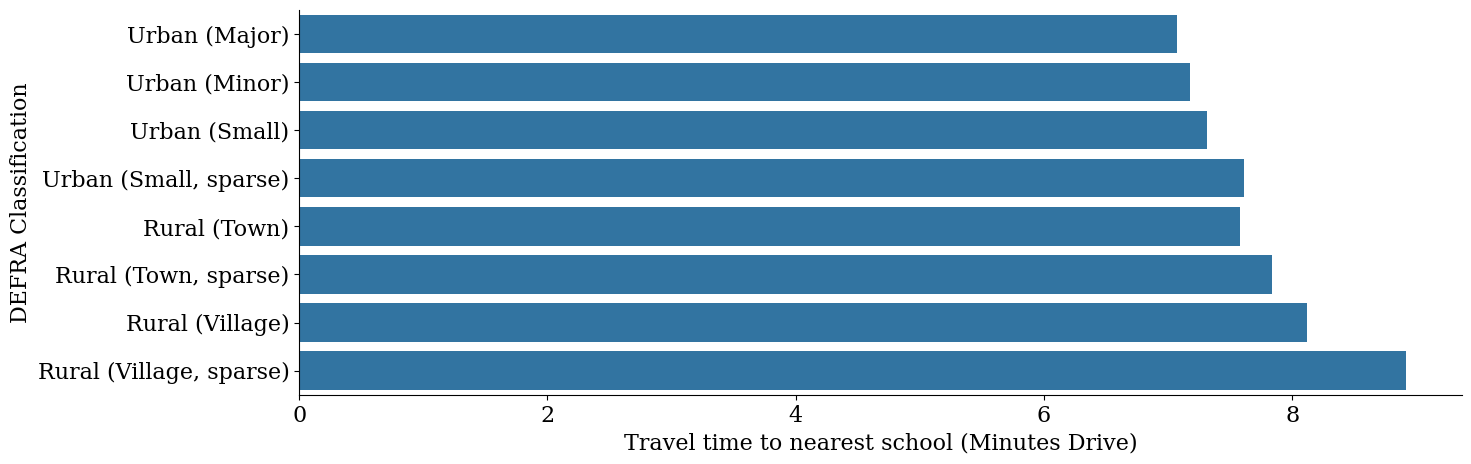

In [15]:
fig, ax = plt.subplots(1, figsize=(15,5))
sns.barplot(x='mins_nearest_school',y='rural_urban_category',data=df_times_defra, ax=ax)
plt.xlabel('Travel time to nearest school (Minutes Drive)')
plt.ylabel('DEFRA Classification')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig(OUT / 'school_times_defra.png', bbox_inches='tight')